**This file contains complete exploratory (sections 1-3), and data analysis(sections 4, 5).**

In [1]:
#Packages preparation
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns

#import sys
#!{sys.executable} -m pip install plspm
import plspm
import plspm.config as c, plspm.util as util
from plspm.plspm import Plspm
from plspm.scale import Scale
from plspm.scheme import Scheme
from plspm.mode import Mode

from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
#!{sys.executable} -m pip install pmdarima
from pmdarima import auto_arima

In [2]:
# import data
final_data = pd.read_csv("finaldata.csv", index_col=0)
final_data = final_data.set_index(['Period'])
crimecovid = pd.read_csv('crimecovid.csv')
coviddata = pd.read_csv("coviddata.csv")
coviddata['date_of_interest'] = pd.to_datetime(coviddata['date_of_interest'])
coviddata = coviddata.set_index(['date_of_interest'])

In [3]:
# Helper function returns mean, median, and std of columns
def getStatistics(data, col1, col2, stat=False, corr=False):
    if stat:
        mean1 = data[col1].mean()
        mean2 = data[col2].mean()
        mid1 = data[col1].median()
        mid2 = data[col2].median()
        std1 = data[col1].std()
        std2 = data[col2].std()
        print("{} mean: {:.2f}, median: {:.2f}, standard deviation: {:.2f}".format(col1, mean1, mid1, std1))
        print("{} mean: {:.2f}, median: {:.2f}, standard deviation: {:.2f}".format(col2, mean2, mid2, std2))
    if corr:
        cov12 = data[col1].cov(data[col2])
        corr12 = data[col1].corr(data[col2])
        print("Covariance between {} and {} is {:.2f}".format(col1, col2, cov12))
        print("Correlation between {} and {} is {:.2f}".format(col1, col2, corr12))

In [4]:
# Helper function produces different types of plots
def plotData(data, col1, col2, lab1, lab2, style="line"):
    if style == "bar":        # bar plot
        data[[col1,col2]].plot.bar()
        plt.title("Relationship between {} and {}".format(col1, col2))
        plt.xlabel(lab1)
        plt.ylabel(lab2)
        #plt.show()
        
    elif style == "pie":      # pie plot
        nyc_Race = data[col1].value_counts()
        NYC_Race = pd.DataFrame()
        NYC_Race['Race'] = nyc_Race.index.tolist()
        NYC_Race['Cases'] = nyc_Race.tolist()
        NYC_Race = NYC_Race.set_index('Race')
        NYC_Race.plot.pie(title=lab1, figsize=(6, 6), subplots=True)
        
    elif style == "scatter":  # scatter plot
        plt.scatter(data[col1], final_data[col2])
        plt.xlabel(lab1)
        plt.ylabel(lab2)
        plt.title(col1 + " vs. " + col2)
        #plt.show()
        
    else:                     # line plot
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('Time')
        ax1.set_ylabel(lab1, color=color)
        ax1.plot(final_data[col1], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx() 
        color = 'tab:blue'
        ax2.set_ylabel(lab2, color=color) 
        ax2.plot(final_data[col2], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()
        plt.title(col1 + " vs. " + col2)
        #plt.show()

In [5]:
# Helper function generate regression outputs and plot
def model_output(X, Y, summary=False, plot=False, title="Linear Regression"):
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X)
    if plot:
        plt.scatter(pd.DataFrame(X).iloc[:,1], Y, color = 'blue')
        plt.plot(pd.DataFrame(X).iloc[:,1], predictions, color = 'red')
        plt.title(title)
        plt.xlabel('COVID predictors')
        plt.ylabel('Crime cases')
    if summary:
        return model.summary()

In [6]:
# Bollinger Bands Helper Functions
def BollingerBands(data, col, days, noStd, method, plot=False):
    """
    Parameter data: the data containing column [col]
    Parameter days: window of moving average
    Parameter noStd: number of standard deviation, the width of bands
    Parameter method: takes either SMA(Simple) or EWMA(Exponentially Weighted)
    Return: updated dataframe with 
            [MA, MA STD, MA Upper Bound, MA Lower Bound, BreakoutSignal]
    """
    # Simple Moving Average
    if method == "SMA":
        data['MA'] = data[col].rolling(window=days).mean()
        data['MA_STD'] = data[col].rolling(window=days).std()
        data['MA_Upper'] = data['MA'] + data['MA_STD'] * noStd
        data['MA_Lower'] = data['MA'] - data['MA_STD'] * noStd
        
    # Exponentially Weighted Moving Average
    else:
        data['MA'] = data[col].ewm(span=days, adjust=False).mean()
        data['MA_STD'] = data[col].ewm(span=days, adjust=False).std()
        data['MA_Upper'] = data['MA'] + data['MA_STD'] * noStd
        data['MA_Lower'] = data['MA'] - data['MA_STD'] * noStd
    
    breakout_upper = np.where(data[col] > data['MA_Upper'], 1, 0)     # +1 when hit upper band
    breakout_lower = np.where(data[col] < data['MA_Lower'], -1, 0)    # -1 when hit lower band
    
    data['BreakoutSignal'] = breakout_upper + breakout_lower
    data['BreakoutSignal'].fillna(method='ffill',inplace=True)    # Forward fill to replace the "None" values
    
    # plot bands
    if plot:
        plt.plot(data[col])
        plt.plot( data[['MA', 'MA_Lower', 'MA_Upper']], alpha=0.7)
        plt.scatter(data[data["BreakoutSignal"] == 1].index, data[data["BreakoutSignal"] == 1][col], c='r')
        plt.scatter(data[data["BreakoutSignal"] == -1].index, data[data["BreakoutSignal"] == -1][col], c='g')
        plt.title( "{} days {} Bollinger Bands of {}".format(str(days), method, col) )
        plt.ylabel(col)

# 1. Univariate Analysis
## 1.1 COVID ###
- The result shows a negative correlation between the total case number in NY and in LA. This is due to different waves of pandemic: the peak in cases of NY took place in April, while in LA the peak was in July.

TotalCasesNY mean: 28698.33, median: 10882.00, standard deviation: 35805.90
TotalCasesLA mean: 28806.89, median: 27127.00, standard deviation: 26210.74
DeathRateNY mean: 0.04, median: 0.03, standard deviation: 0.04
DeathRateLA mean: 0.02, median: 0.02, standard deviation: 0.02


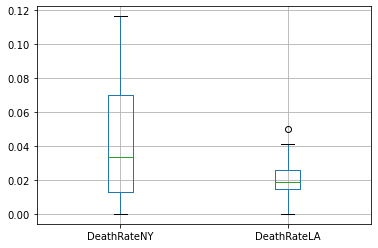

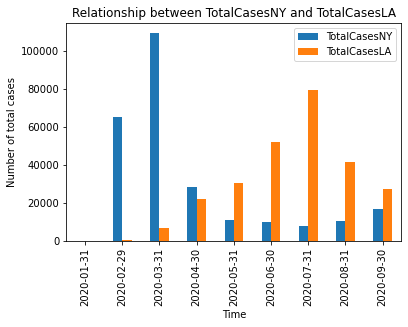

In [7]:
# Summary Statistics of COVID variable
getStatistics(final_data, "TotalCasesNY", "TotalCasesLA", True)
getStatistics(final_data, "DeathRateNY", "DeathRateLA", True)
# Plot of COVID variable
final_data.boxplot(column=['DeathRateNY', 'DeathRateLA'])
plotData(final_data, 'TotalCasesNY', 'TotalCasesLA', "Time", 'Number of total cases', style="bar")

## 1.2 Jail

JailPpltNY mean: 4452.50, median: 3972.50, standard deviation: 762.85
JailPpltLA mean: 5597.56, median: 5758.00, standard deviation: 427.90


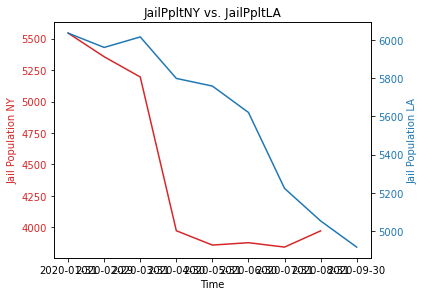

In [8]:
# Summary Statistics of JailPply variable
getStatistics(final_data, "JailPpltNY", "JailPpltLA", True)
# Plot of Covid variable
plotData(final_data, 'JailPpltNY', 'JailPpltLA', 'Jail Population NY', 'Jail Population LA')

## 1.3 Unemployment ###
- Mean and standard deviationof unemployment rate in LA is higher than NY
- There is a positive correlation between unemployment rate in NY and LA from January to August 2020. The unemployment rate began surging in March and maintained at a relatively high level. It shows a decreasing trend beginning with June.

UnemplNY mean: 12.71, median: 15.00, standard deviation: 7.10
UnemplLA mean: 12.88, median: 15.00, standard deviation: 6.41
Covariance between UnemplNY and UnemplLA is 43.65
Correlation between UnemplNY and UnemplLA is 0.96


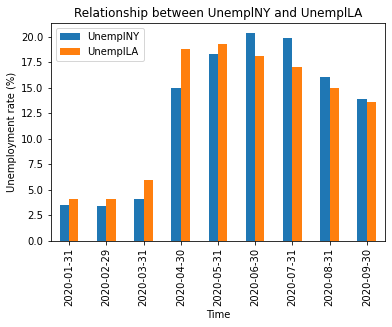

In [9]:
# Summary Statistics of Unempl variable
getStatistics(final_data, "UnemplNY", "UnemplLA", True, True)
# Plot of Unempl variable
plotData(final_data, 'UnemplNY', 'UnemplLA', "Time", 'Unemployment rate (%)', style="bar")

## 1.4 Weekly working Hours ###
- Mean and standard deviation of working hour in LA is higher than NY
- There is a positive correlation between work hour in NY and LA from January to August 2020.

WorkHrNY mean: 33.49, median: 33.50, standard deviation: 0.45
WorkHrLA mean: 34.79, median: 34.60, standard deviation: 0.56
Covariance between WorkHrNY and WorkHrLA is 0.24
Correlation between WorkHrNY and WorkHrLA is 0.95


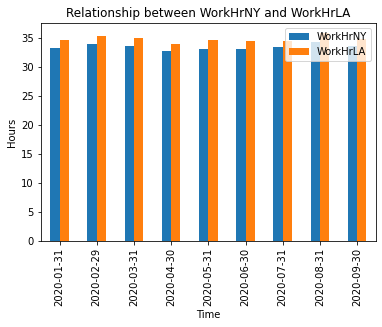

In [10]:
# Summary Statistics of WorkHr variable
getStatistics(final_data, "WorkHrNY", "WorkHrLA", True, True)
# Plot of WorkHr variable
plotData(final_data, 'WorkHrNY', 'WorkHrLA', "Time", 'Hours', style="bar")

## 1.5 Computer Service Employee ###

CompEmplNY mean: 70.11, median: 69.20, standard deviation: 2.31
CompEmplLA mean: 63.09, median: 63.20, standard deviation: 0.78


<AxesSubplot:>

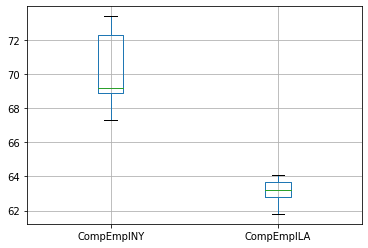

In [11]:
# Summary Statistics of CompEmpl variable
getStatistics(final_data, "CompEmplNY", "CompEmplLA", True)
# Plot of CompEmpl variable
final_data.boxplot(column=["CompEmplNY", "CompEmplLA"])

## 1.6 Local Government Employee ###

GovEmplNY mean: 476.64, median: 486.40, standard deviation: 27.00
GovEmplLA mean: 554.94, median: 558.60, standard deviation: 33.93


<AxesSubplot:>

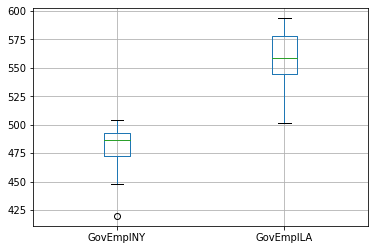

In [12]:
# Summary Statistics of GovEmpl variable
getStatistics(final_data, "GovEmplNY", "GovEmplLA", True)
# Plot of GovEmpl variable
final_data.boxplot(column=["GovEmplNY", "GovEmplLA"])

## 1.7 Hopsital Employee ###

HospEmplNY mean: 166.27, median: 165.60, standard deviation: 1.48
HospEmplLA mean: 153.98, median: 154.10, standard deviation: 1.16


<AxesSubplot:>

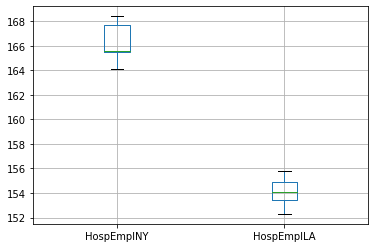

In [13]:
# Summary Statistics of HospEmpl variable
getStatistics(final_data, "HospEmplNY", "HospEmplLA", True)
# Plot of HospEmpl variable
final_data.boxplot(column=["HospEmplNY", "HospEmplLA"])

##  1.8 Financial Activities Employee ###

FinEmplNY mean: 461.29, median: 456.40, standard deviation: 9.08
FinEmplLA mean: 336.92, median: 335.80, standard deviation: 6.76


<AxesSubplot:>

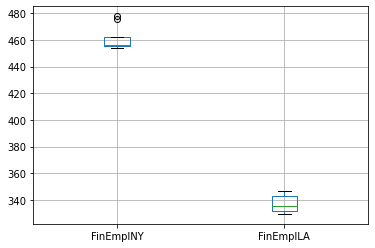

In [14]:
# Summary Statistics of FinEmpl variable
getStatistics(final_data, "FinEmplNY", "FinEmplLA", True)
# Plot of FinEmpl variable
final_data.boxplot(column=["FinEmplNY", "FinEmplLA"])

## 1.9 Educational Services Employee ###

EduEmplNY mean: 228.27, median: 221.80, standard deviation: 21.89
EduEmplLA mean: 163.26, median: 162.70, standard deviation: 13.15


<AxesSubplot:>

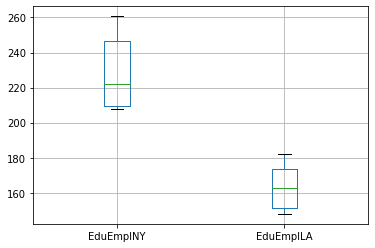

In [15]:
# Summary Statistics of EduEmpl variable
getStatistics(final_data, "EduEmplNY", "EduEmplLA", True)
# Plot of EduEmpl variable
final_data.boxplot(column=["EduEmplNY", "EduEmplLA"])

## 1.10 Crime ###
- Curve of number of compaints is generally pretty flat for LA, which contradicts a lot with the curve of NYC. Which can also be seen from the comparison of NYC's standard deviation with LA. The magnitude of NYC's mean and LA's mean would largely dependent on the size of city, and thus less helpful with the analysis here.

CrimeNY mean: 33212.11, median: 33147.00, standard deviation: 3885.73
CrimeLA mean: 16019.89, median: 16314.00, standard deviation: 899.26


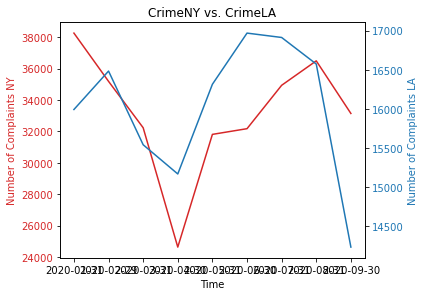

In [16]:
# Summary Statistics of Crime variable
getStatistics(final_data, "CrimeNY", "CrimeLA", True)
# Plot of Covid variable
plotData(final_data, 'CrimeNY', 'CrimeLA', 'Number of Complaints NY', 'Number of Complaints LA')

**Some Exploration of demographic variables that might help with future analysis** 
- This section is commented out because it requires unzipping ManipulatedData folder.

In [17]:
#nyc_crime = pd.read_csv('ManipulatedData/NYPD_Complaint_Data_Current__Year_To_Date_.csv')
#nyc_crime_new = nyc_crime[['SUSP_AGE_GROUP','SUSP_RACE','SUSP_SEX','VIC_AGE_GROUP','VIC_RACE','VIC_SEX']].copy()

#plotData(nyc_crime_new, 'SUSP_RACE', '', "Suspect Race of Crime in NYC", '', style="pie")
#plotData(nyc_crime_new, 'VIC_RACE', '', "Victim Race of Crime in NYC", '', style="pie")

# 2. Bivariate Analysis ##
## 2.1 Unempl vs. COVID ###
- There is insignificant correlation between the total number of cases in NY and the unemployment rate. However, the cumulative cases in NY peaked in April, and unemployment rate soon reached the highest level in around June.
- There is a relatively high correlation between the total number of cases in LA and the unemployment rate. When the number of cumulative cases increase, the unemployment rate is likely to increase.

Covariance between TotalCasesNY and UnemplNY is -155007.54
Correlation between TotalCasesNY and UnemplNY is -0.61


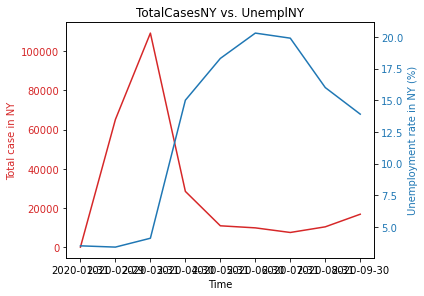

In [18]:
getStatistics(final_data, "TotalCasesNY", "UnemplNY", False, True)

# Plot of Unempl vs. COVID variable
plotData(final_data, 'TotalCasesNY', 'UnemplNY', 'Total case in NY', 'Unemployment rate in NY (%)')

Covariance between TotalCasesLA and UnemplLA is 123263.41
Correlation between TotalCasesLA and UnemplLA is 0.73


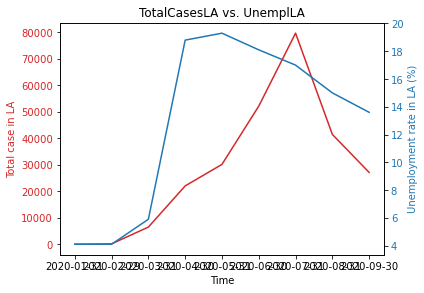

In [19]:
getStatistics(final_data, "TotalCasesLA", "UnemplLA", False, True)

# Plot of Unempl vs. COVID variable
plotData(final_data, 'TotalCasesLA', 'UnemplLA', 'Total case in LA', 'Unemployment rate in LA (%)')

## 2.2 Crime vs. COVID ###
- NYC crime complaints and covid cases appears to be negatively correlated, and the relationship is strong. The negative correlation score approves a pattern that when the crime complaints in high in NY, total covid cases are likely to be low. 
- In comparison, the correlation between crime complaints and covid cases in LA seems to be weaker but the correlation is positive. An increase in crime is likely to be followed by an increase in covid case in LA. 

Covariance between CrimeNY and TotalCasesNY is -25143455.79
Correlation between CrimeNY and TotalCasesNY is -0.18


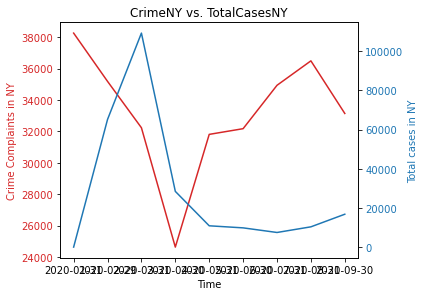

In [20]:
getStatistics(final_data, "CrimeNY", "TotalCasesNY", False, True)

# Plot of Crime vs. COVID variable
plotData(final_data, 'CrimeNY', 'TotalCasesNY', "Crime Complaints in NY", 'Total cases in NY')

Covariance between CrimeLA and TotalCasesLA is 10261056.61
Correlation between CrimeLA and TotalCasesLA is 0.44


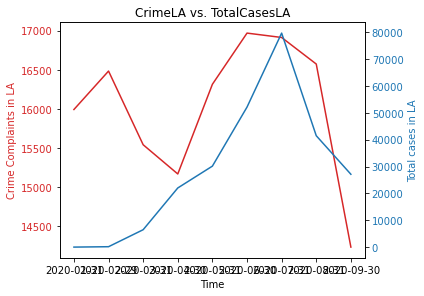

In [21]:
getStatistics(final_data, "CrimeLA", "TotalCasesLA", False, True)

# Plot of Crime vs. COVID variable
plotData(final_data, 'CrimeLA', 'TotalCasesLA', "Crime Complaints in LA", 'Total cases in LA')

## 2.3 Crime vs. Jailpplt ###

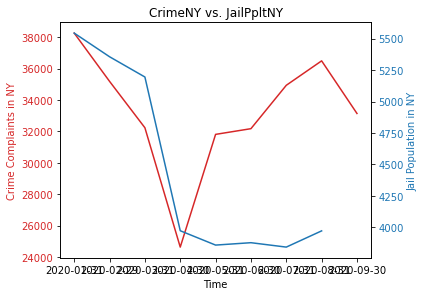

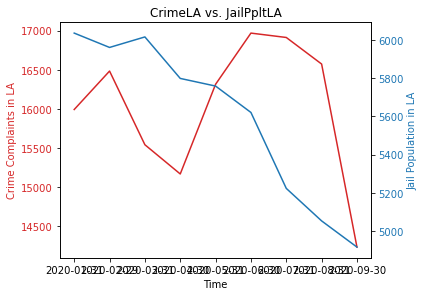

In [22]:
plotData(final_data, 'CrimeNY', 'JailPpltNY', "Crime Complaints in NY", 'Jail Population in NY')
plotData(final_data, 'CrimeLA', 'JailPpltLA', "Crime Complaints in LA", 'Jail Population in LA')

# 3 Multivariate Analysis ##
## 3.1 Employee Number vs. COVID ###
- The color of each block represents the correlation value of the two variables. The higher the value is, the warmer the color will be, vis versa.
- According to the correlation plot, the number of employees in different industries changes differently towards the pandemic’s impact. It is worthy to notice that there is a dramatic difference in the hospital industry between these two cities.
- Although this dataset's size is small, the difference between New York and Los Angeles in hospital industry's employees’ number is significant. The former is positively correlated to the death rate of the COVID pandemic, while the latter has a negative correlation with it.

In [23]:
# visualize the correlation between different variables of NY
cov_empl_ny = final_data[['TotalCasesNY', 'TotalDeathsNY', 'DeathRateNY', 'CompEmplNY', 'GovEmplNY', 'HospEmplNY', 'FinEmplNY',  'EduEmplNY']]

corr_ny = cov_empl_ny.corr()    # visualize correlation matrix
corr_ny.style.background_gradient(cmap='coolwarm') 

,TotalCasesNY,TotalDeathsNY,DeathRateNY,CompEmplNY,GovEmplNY,HospEmplNY,FinEmplNY,EduEmplNY
TotalCasesNY,1.000000,0.918605,0.663158,0.675537,0.548240,0.487976,0.271178,0.743525
TotalDeathsNY,0.918605,1.000000,0.775531,0.580947,0.466383,0.371971,0.063835,0.632856
DeathRateNY,0.663158,0.775531,1.000000,0.343697,0.387797,-0.101168,-0.288972,0.385556
CompEmplNY,0.675537,0.580947,0.343697,1.000000,0.564897,0.830824,0.729195,0.971221
GovEmplNY,0.548240,0.466383,0.387797,0.564897,1.000000,0.390886,0.391687,0.689067
HospEmplNY,0.487976,0.371971,-0.101168,0.830824,0.390886,1.000000,0.879543,0.803431
FinEmplNY,0.271178,0.063835,-0.288972,0.729195,0.391687,0.879543,1.000000,0.744646
EduEmplNY,0.743525,0.632856,0.385556,0.971221,0.689067,0.803431,0.744646,1.000000


In [24]:
# visualize the correlation between different variables of LA
cov_empl_la = final_data[['TotalCasesLA', 'TotalDeathsLA', 'DeathRateLA', 'CompEmplLA', 'GovEmplLA', 'HospEmplLA', 'FinEmplLA',  'EduEmplLA']]

corr_la = cov_empl_la.corr()     # visualize correlation matrix
corr_la.style.background_gradient(cmap='coolwarm')

,TotalCasesLA,TotalDeathsLA,DeathRateLA,CompEmplLA,GovEmplLA,HospEmplLA,FinEmplLA,EduEmplLA
TotalCasesLA,1.000000,0.790304,0.250377,-0.153588,-0.837340,0.503509,-0.506051,-0.840876
TotalDeathsLA,0.790304,1.000000,0.756074,-0.569318,-0.686660,0.837315,-0.848457,-0.769698
DeathRateLA,0.250377,0.756074,1.000000,-0.739925,-0.179009,0.871626,-0.806810,-0.349090
CompEmplLA,-0.153588,-0.569318,-0.739925,1.000000,-0.105893,-0.740727,0.652434,0.055498
GovEmplLA,-0.837340,-0.686660,-0.179009,-0.105893,1.000000,-0.238200,0.405951,0.926029
HospEmplLA,0.503509,0.837315,0.871626,-0.740727,-0.238200,1.000000,-0.805790,-0.399207
FinEmplLA,-0.506051,-0.848457,-0.806810,0.652434,0.405951,-0.805790,1.000000,0.649978
EduEmplLA,-0.840876,-0.769698,-0.349090,0.055498,0.926029,-0.399207,0.649978,1.000000


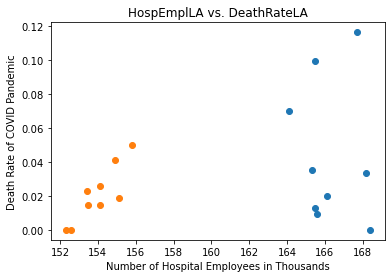

In [25]:
#take a close look at the hospital industry
plotData(final_data, "HospEmplNY", "DeathRateNY", 'Number of Hospital Employees in Thousands', 'Death Rate of COVID Pandemic', style="scatter")
plotData(final_data, "HospEmplLA", "DeathRateLA", 'Number of Hospital Employees in Thousands', 'Death Rate of COVID Pandemic', style="scatter")

# 4. Linear Regression 
## 4.1 Simple Linear Regression on Monthly Data
__Hypotheses__:
1. Crime cases in NY has negative correlation with average working hour;
2. Crime cases in NY has positive correlation unemployment with unemployment rate.
3. Crime cases in NY has positive/negatibve correlation with total death counts from covid-19.
4. Crime cases in NY has positive correlation with total covid cases;



__Interpreting Results:__
- Economic variables, such as Average weekly work hours has $R^2$ relatively low compared to COVID predictors. They explain less variability in crime cases in NY.

- Failure:The sign of regression slope contradicts to all our hypothesis respectively. It could be explained by that many factors contribute to crime cases with different weight.Some extremely sigficant factor might pull the net effect of some factors to another side.



In [26]:
variables = {'TotalCasesNY','TotalDeathsNY','UnemplNY','WorkHrNY'}
final_data = final_data[:7]
for i in variables:
    X = final_data[[i]]
    y = final_data['CrimeNY']
    reg = LinearRegression()
    reg.fit(X,y)
    print("The name of predictor variable: {}".format(i))
    print("The regression slope: {}".format(reg.coef_))
    print("The r^2 score: {}".format(reg.score(final_data[[i]] , final_data['CrimeNY']))+'\n')

The name of predictor variable: TotalDeathsNY
The regression slope: [-0.19970737]
The r^2 score: 0.04559412468569635

The name of predictor variable: WorkHrNY
The regression slope: [7785.69852941]
The r^2 score: 0.4341449603350358

The name of predictor variable: TotalCasesNY
The regression slope: [-0.01323937]
The r^2 score: 0.015584282511015624

The name of predictor variable: UnemplNY
The regression slope: [-209.7660679]
The r^2 score: 0.15757353193816293



## 4.2 Attempt Multivariate Linear Regression on monthly data
### Plan to run the following models for NY:
![title](model.png)

__Interpreting Results:__
- For all the models, p-values of most predeicters are much greater than the accpetable level (0.05), suggesting the null hypothesis couldn't be rejected.
- Potentail reasons: 
1. We suppossed it could be caused by the low number of entries (since we accumulated stats to show only monthly data). <br/>
_Solution_: We decided to use daily data to re-test.But since unemployment data and employment in each industry can't find daily data; We would only use covid data, see 4.1.4 and 4.1.5. 
2. Multicollinearity between predictors.<br/>
_Solution_: Try Partial Least Square model on monthly data, see 4.1.3 .

Regression Model 1

In [27]:
X = final_data[['TotalCasesNY','TotalDeathsNY','UnemplNY']]
y = final_data['CrimeNY']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrimeNY   R-squared (uncentered):                   0.851
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                              7.631
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                      0.0394
Time:                        17:55:46   Log-Likelihood:                         -76.090
No. Observations:                   7   AIC:                                      158.2
Df Residuals:                       4   BIC:                                      158.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
TotalCasesNY      0.5382      0.375      1.437      0.224      -0.502       1.578
TotalDeathsNY    -2.6736      3.620     -0.739      0.501     -12.725       7.378
UnemplNY       1518.0036    482.847      3.144      0.035     177.405    2858.603
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.014
Prob(Omnibus):                    nan   Jarque-Bera (JB):                4.990
Skew:                           1.860   Prob(JB):                       0.0825
Kurtosis:                       4.810   Cond. No.                     3.79e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Regression Model 2

In [28]:
X = final_data[['TotalCasesNY','TotalDeathsNY','DeathRateNY','UnemplNY','WorkHrNY']]
y = final_data['CrimeNY']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrimeNY   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              253.9
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                     0.00393
Time:                        17:55:46   Log-Likelihood:                         -60.168
No. Observations:                   7   AIC:                                      130.3
Df Residuals:                       2   BIC:                                      130.1
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
TotalCasesNY     -0.0240      0.070     -0.343      0.764      -0.326       0.278
TotalDeathsNY     0.7998      0.660      1.212      0.349      -2.039       3.639
DeathRateNY   -1.224e+05   4.42e+04     -2.768      0.110   -3.13e+05    6.78e+04
UnemplNY        -54.3277    192.219     -0.283      0.804    -881.381     772.725
WorkHrNY       1157.1524     87.633     13.205      0.006     780.099    1534.206
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.301
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.813
Skew:                           0.812   Prob(JB):                        0.666
Kurtosis:                       3.388   Cond. No.                     2.38e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Regression Model 3

In [29]:
X = final_data[['TotalCasesNY','TotalDeathsNY','DeathRateNY','GovEmplNY','HospEmplNY']]
y = final_data['CrimeNY']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrimeNY   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              206.7
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                     0.00482
Time:                        17:55:46   Log-Likelihood:                         -60.886
No. Observations:                   7   AIC:                                      131.8
Df Residuals:                       2   BIC:                                      131.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
TotalCasesNY     -0.0107      0.074     -0.145      0.898      -0.328       0.307
TotalDeathsNY     0.7739      0.734      1.054      0.402      -2.385       3.933
DeathRateNY   -1.307e+05   4.18e+04     -3.127      0.089   -3.11e+05    4.91e+04
GovEmplNY         8.5192     51.200      0.166      0.883    -211.775     228.813
HospEmplNY      203.7611    141.348      1.442      0.286    -404.409     811.931
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.391
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.656
Skew:                           0.738   Prob(JB):                        0.720
Kurtosis:                       3.263   Cond. No.                     2.03e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Regression Model 4

In [30]:
X = final_data[['TotalCasesNY','TotalDeathsNY','DeathRateNY','CompEmplNY','GovEmplNY','HospEmplNY','FinEmplNY','EduEmplNY']]
y = final_data['CrimeNY']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1698: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1698: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                CrimeNY   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                nan
Time:                        17:55:46   Log-Likelihood:                 114.33
No. Observations:                   7   AIC:                            -214.7
Df Residuals:                       0   BIC:                            -215.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
TotalCasesNY     -0.1887        inf         -0        nan         nan         nan
TotalDeathsNY     7.7330        inf          0        nan         nan         nan
DeathRateNY    1814.6420        inf          0        nan         nan         nan
CompEmplNY     3.611e+04        inf          0        nan         nan         nan
GovEmplNY       299.8413        inf          0        nan         nan         nan
HospEmplNY     -2.45e+04        inf         -0        nan         nan         nan
FinEmplNY      5417.6795        inf          0        nan         nan         nan
EduEmplNY     -4743.8448        inf         -0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.442
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.966
Skew:                          -0.434   Prob(JB):                        0.617
Kurtosis:                       1.401   Cond. No.                     1.86e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
[3] The condition number is large, 1.86e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Regression Model 5

In [31]:
X = final_data[['CompEmplNY','GovEmplNY','HospEmplNY','FinEmplNY','EduEmplNY']]
y = final_data['CrimeNY']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrimeNY   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              75.22
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                      0.0132
Time:                        17:55:46   Log-Likelihood:                         -64.413
No. Observations:                   7   AIC:                                      138.8
Df Residuals:                       2   BIC:                                      138.6
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CompEmplNY  1.368e+04   3.74e+04      0.365      0.750   -1.47e+05    1.75e+05
GovEmplNY    -19.9937    257.296     -0.078      0.945   -1127.051    1087.064
HospEmplNY -5448.4609   1.32e+04     -0.414      0.719   -6.21e+04    5.12e+04
FinEmplNY    467.8486    434.579      1.077      0.394   -1401.995    2337.692
EduEmplNY  -1012.0128   2924.733     -0.346      0.762   -1.36e+04    1.16e+04
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.764
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.589
Skew:                          -0.488   Prob(JB):                        0.745
Kurtosis:                       1.968   Cond. No.                     1.71e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### LA Multivariate Linear Regression
Regession model 1 considering total cases, total death and death rates in Los Angeles as independent variables, and crime rate in Los Angeles as dependent variable is not an ideal model given the large p-values (>0.2) and potential multicollinearity issue.

In [32]:
X = final_data[['TotalCasesLA', 'TotalDeathsLA', 'DeathRateLA']]
y = final_data["CrimeLA"]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrimeLA   R-squared (uncentered):                   0.684
Model:                            OLS   Adj. R-squared (uncentered):              0.446
Method:                 Least Squares   F-statistic:                              2.880
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                       0.167
Time:                        17:55:46   Log-Likelihood:                         -73.759
No. Observations:                   7   AIC:                                      153.5
Df Residuals:                       4   BIC:                                      153.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
TotalCasesLA      0.5160      0.525      0.982      0.382      -0.943       1.975
TotalDeathsLA   -28.0668     41.560     -0.675      0.536    -143.456      87.323
DeathRateLA    7.788e+05   7.66e+05      1.017      0.367   -1.35e+06    2.91e+06
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.546
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.694
Skew:                           0.489   Prob(JB):                        0.707
Kurtosis:                       1.807   Cond. No.                     6.51e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.51e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

--- 
Regession model 2 considering total cases, total death, death rates, jail people, unemployment rate, work hours in Los Angeles as independent variables, and crime rate in Los Angeles as dependent variable is not an ideal model given the large p-values (>0.4) for two of the variables and potential multicollinearity issue.

In [33]:
X = final_data[['TotalCasesLA', 'TotalDeathsLA', 'DeathRateLA','JailPpltLA','UnemplLA','WorkHrLA']]
y = final_data["CrimeLA"]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrimeLA   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.924e+04
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                     0.00345
Time:                        17:55:46   Log-Likelihood:                         -33.699
No. Observations:                   7   AIC:                                      79.40
Df Residuals:                       1   BIC:                                      79.07
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
TotalCasesLA     -0.0198      0.006     -3.587      0.173      -0.090       0.050
TotalDeathsLA     0.7389      0.587      1.260      0.427      -6.714       8.192
DeathRateLA   -6.666e+04   6090.951    -10.945      0.058   -1.44e+05    1.07e+04
JailPpltLA       -0.6827      0.540     -1.265      0.426      -7.538       6.173
UnemplLA        163.8160     41.395      3.957      0.158    -362.154     689.786
WorkHrLA        562.2089     89.446      6.285      0.100    -574.305    1698.723
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.270
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.377
Skew:                           0.197   Prob(JB):                        0.828
Kurtosis:                       1.934   Cond. No.                     7.96e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.96e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---
Regession model 3 considering total cases, total death, death rates, government employment, hospital employment in Los Angeles as independent variables, and crime rate in Los Angeles as dependent variable is not an ideal model given the large p-values (>0.2) for three of the variables and potential multicollinearity issue.

In [34]:
X = final_data[['TotalCasesLA', 'TotalDeathsLA', 'DeathRateLA','GovEmplLA','HospEmplLA']]
y = final_data["CrimeLA"]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrimeLA   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                              8378.
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                    0.000119
Time:                        17:55:46   Log-Likelihood:                         -42.962
No. Observations:                   7   AIC:                                      95.92
Df Residuals:                       2   BIC:                                      95.65
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
TotalCasesLA     -0.0070      0.013     -0.553      0.636      -0.061       0.047
TotalDeathsLA     3.4377      0.845      4.068      0.055      -0.199       7.074
DeathRateLA   -9.003e+04   1.63e+04     -5.508      0.031    -1.6e+05   -1.97e+04
GovEmplLA        20.1161     11.179      1.799      0.214     -27.983      68.215
HospEmplLA       29.6811     42.976      0.691      0.561    -155.232     214.594
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.859
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.913
Skew:                          -0.212   Prob(JB):                        0.634
Kurtosis:                       1.283   Cond. No.                     8.00e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  8e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---
Regession model 4 considering total cases, total death, death rates, company employment, government employment, hospital employment, financial employment, education employment in Los Angeles as independent variables, and crime rate in Los Angeles as dependent variable is not an ideal model given the large p-values (>0.2) for all of the variables and potential multicollinearity issue.

In [35]:
X = final_data[['TotalCasesLA', 'TotalDeathsLA', 'DeathRateLA','CompEmplLA','GovEmplLA','HospEmplLA','FinEmplLA','EduEmplLA']]
y = final_data["CrimeLA"]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                CrimeLA   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                nan
Time:                        17:55:46   Log-Likelihood:                 135.44
No. Observations:                   7   AIC:                            -256.9
Df Residuals:                       0   BIC:                            -257.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
TotalCasesLA     -0.0846        inf         -0        nan         nan         nan
TotalDeathsLA     8.2419        inf          0        nan         nan         nan
DeathRateLA     -99.8067        inf         -0        nan         nan         nan
CompEmplLA     2743.9213        inf          0        nan         nan         nan
GovEmplLA       135.4145        inf          0        nan         nan         nan
HospEmplLA    -1432.6825        inf         -0        nan         nan         nan
FinEmplLA       174.2390        inf          0        nan         nan         nan
EduEmplLA      -443.2696        inf         -0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.815
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.562
Skew:                          -0.673   Prob(JB):                        0.755
Kurtosis:                       2.659   Cond. No.                     2.82e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
[3] The condition number is large, 2.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---
Regession model 5 considering total cases, company employment, government employment, hospital employment, financial employment, education employment in Los Angeles as independent variables, and crime rate in Los Angeles as dependent variable is not an ideal model given the large p-values (>0.3) for all of the variables and potential multicollinearity issue.

In [36]:
X = final_data[['TotalCasesLA','CompEmplLA','GovEmplLA','HospEmplLA','FinEmplLA','EduEmplLA']]
y = final_data["CrimeLA"]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrimeLA   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              418.8
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                      0.0374
Time:                        17:55:46   Log-Likelihood:                         -50.382
No. Observations:                   7   AIC:                                      112.8
Df Residuals:                       1   BIC:                                      112.4
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
TotalCasesLA    -0.0049      0.061     -0.080      0.949      -0.778       0.768
CompEmplLA    1075.1944   1055.134      1.019      0.494   -1.23e+04    1.45e+04
GovEmplLA       11.8880     54.455      0.218      0.863    -680.034     703.810
HospEmplLA    -137.2197    222.664     -0.616      0.648   -2966.428    2691.989
FinEmplLA      -70.3409    146.355     -0.481      0.715   -1929.951    1789.270
EduEmplLA      -78.5570    200.263     -0.392      0.762   -2623.141    2466.027
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.751
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.197
Skew:                           0.405   Prob(JB):                        0.906
Kurtosis:                       3.135   Cond. No.                     1.28e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 4.3 Attempt Partial Least Squares Model
__Advantage of PLS:__ PLS regression is particularly suited when the matrix of predictors has more variables than observations, and when there is multicollinearity among X values
Tutorial Source：https://plspm.readthedocs.io/en/latest/

__Interpreting Result:__ The p values for 'Covid case','Death','Unemployment' still much greater than 0.05, suggesting null hypothesis couldn't be rejected. p value for 'covid case' -> 'Death' proves significant, which makes intuitive sense; p value for 'unemployment' -> 'Jail population' also proves significant.

In [37]:
structure = c.Structure()
structure.add_path(['Covid'],['Death','Jail','Crime'])
structure.add_path(['Unemployment'],['Death','Crime','Jail'])
structure.add_path(['Death'],['Crime','Jail'])
structure.add_path(['Crime'],['Jail'])

config = c.Config(structure.path(), scaled = False)
config.add_lv_with_columns_named("Covid", Mode.A, final_data, "TotalCasesNY")
config.add_lv_with_columns_named("Death", Mode.A, final_data, "TotalDeathsNY")
config.add_lv_with_columns_named("Unemployment", Mode.A, final_data, "UnemplNY")
config.add_lv_with_columns_named("Jail", Mode.A, final_data, "JailPpltNY")
config.add_lv_with_columns_named("Crime", Mode.A, final_data, "CrimeNY")

plspm_calc = Plspm(final_data, config, Scheme.CENTROID)
print(plspm_calc.inner_summary())
print(plspm_calc.path_coefficients())
print(plspm_calc.inner_model())

                    type  r_squared  r_squared_adj  block_communality  \
Covid          Exogenous   0.000000       0.000000                1.0   
Crime         Endogenous   0.371987      -0.256025                1.0   
Death         Endogenous   0.843795       0.765693                1.0   
Jail          Endogenous   0.994171       0.982514                1.0   
Unemployment   Exogenous   0.000000       0.000000                1.0   

              mean_redundancy  ave  
Covid                0.000000  1.0  
Crime                0.371987  1.0  
Death                0.843795  1.0  
Jail                 0.994171  1.0  
Unemployment         0.000000  1.0  
              Unemployment     Covid     Death     Crime  Jail
Unemployment      0.000000  0.000000  0.000000  0.000000     0
Covid             0.000000  0.000000  0.000000  0.000000     0
Death            -0.108009  0.978391  0.000000  0.000000     0
Crime            -0.691376  0.250128  0.310576  0.000000     0
Jail              0.9335

## 4.4 Attempt with Polynomial Regression on Daily Covid and Crime Data

__Interpreting Results:__
The root mean square error is still high for both model with predictors of 'CaseNY' or 'DeathNY' , showing polynomial regression also doesn't fit very well.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                CrimeNY   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     12.68
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           3.02e-09
Time:                        17:55:46   Log-Likelihood:                -1376.0
No. Observations:                 212   AIC:                             2762.
Df Residuals:                     207   BIC:                             2779.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1102.4411     29.720     37.095      0.000    1043.849    1161.033
x1            -0.3054      0.106     -2.882      0.004      -0.514      -0.096
x2             0.0003   8.19e-05      3.550      0.000       0.000       0.000
x3         -7.598e-08   2.21e-08     -3.442      0.001    -1.2e-07   -3.25e-08
x4           6.11e-12   1.89e-12      3.228      0.001    2.38e-12    9.84e-12
==============================================================================
Omnibus:                       28.072   Durbin-Watson:                   0.543
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.990
Skew:                           0.622   Prob(JB):                     5.70e-14
Kurtosis:                       5.315   Cond. No.                     6.84e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.84e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

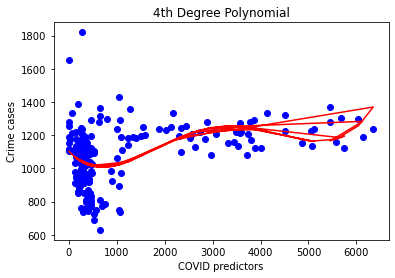

In [38]:
X = crimecovid[['CaseNY']]
X_poly = PolynomialFeatures(degree = 4).fit_transform(X)
model_output(X_poly, crimecovid['CrimeNY'], summary=True, plot=True, title="4th Degree Polynomial")

For the linear plot, we can see the returned line of regression is __upward__. When "Daily NY covid case" is low, "Crime case" is very spread out from around 600 to 1800, but the most are condensed toward the lower part. As daily covid cases increases, the crime cases numbr align closer around the line. 

For the range where "Daily NY covid case" falls between 1000 and 2500, there seem to be a little __'hump'__. We suspect it could possibly curvilinear relationship. We can see the returned polynomial lines doesn't capture the hypothetical "hump" we identified. __Therefore, simple linear regression would still be so far the best model we can use to capture relationship between Daily Crime and Covid.__

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                CrimeLA   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     8.145
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           4.05e-06
Time:                        17:55:47   Log-Likelihood:                -1175.7
No. Observations:                 212   AIC:                             2361.
Df Residuals:                     207   BIC:                             2378.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        453.8637     18.260     24.855      0.000     417.864     489.864
x1             0.4152      0.076      5.472      0.000       0.266       0.565
x2            -0.0005   9.61e-05     -5.351      0.000      -0.001      -0.000
x3          2.216e-07    4.4e-08      5.041      0.000    1.35e-07    3.08e-07
x4         -3.091e-11    6.5e-12     -4.757      0.000   -4.37e-11   -1.81e-11
==============================================================================
Omnibus:                        3.782   Durbin-Watson:                   1.139
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.470
Skew:                          -0.306   Prob(JB):                        0.176
Kurtosis:                       3.133   Cond. No.                     1.49e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

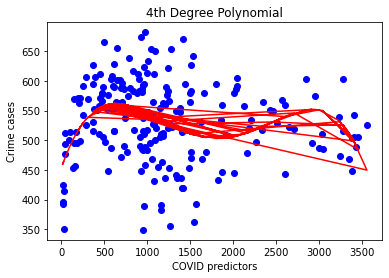

In [39]:
X = crimecovid[['CaseLA']]
X_poly = PolynomialFeatures(degree = 4).fit_transform(X)
model_output(X_poly, crimecovid['CrimeLA'], summary=True, plot=True, title="4th Degree Polynomial")

## 4.5 Attempt Linear Regression on daily data of COVID and crime data
### NY
__Interpretation on Results__:
From the results of this regression model with Cases and Total death in New York City as the independent variable, and Crime number in NYC as the dependent variable, we can conclude some meaningful patterns.
- ${R^2}$ = 0.408, Ajusted ${R^2}$ = 0.402: this model provides a low but valid value, since it represent our findings.
- **Hypothesis Testing**
   - Ho: coefficient of Cases in NYC = 0, Ha: coefficient of Cases in NYC ≠ 0.
   - p-values for Cases in NYC = 0.00
   - T-test here is lower than 0.05 thus proved significant, thus the result is strong enough to reject the null hypothesis.
   - Ho: coefficient of Death in = 0, Ha: coefficient of Death in ≠ 0.
   - p-values for Cases in NYC = 0.492
   - T-test here is much greater than 0.05 thus proved insignificant, thus the result is NOT strong enough to reject the null hypothesis.
- From the coefficients: Sign of coefficient of CaseNY and CrimeNY is positive, indicating positive correlation; One unit of increase in CaseNY sees 0.4066 increase in crime on average.
- From the coefficients: Sign of coefficient of DeathNY and CrimeNY is negative, indicating negative correlation. One unit of increase in CaseNY sees 0.4837 decrease in crime on average, which runs afoul with our prediction.

In [40]:
##Evaluate the two pairs of Linear Regression with Statsmodel
X = crimecovid[['CaseNY','DeathNY']]
y = crimecovid['CrimeNY']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrimeNY   R-squared (uncentered):                   0.408
Model:                            OLS   Adj. R-squared (uncentered):              0.402
Method:                 Least Squares   F-statistic:                              72.39
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                    1.22e-24
Time:                        17:55:47   Log-Likelihood:                         -1728.1
No. Observations:                 212   AIC:                                      3460.
Df Residuals:                     210   BIC:                                      3467.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CaseNY         0.4066      0.066      6.162      0.000       0.277       0.537
DeathNY       -0.4837      0.702     -0.689      0.492      -1.867       0.900
==============================================================================
Omnibus:                       63.445   Durbin-Watson:                   0.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.054
Skew:                          -1.526   Prob(JB):                     1.41e-26
Kurtosis:                       5.039   Cond. No.                         23.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

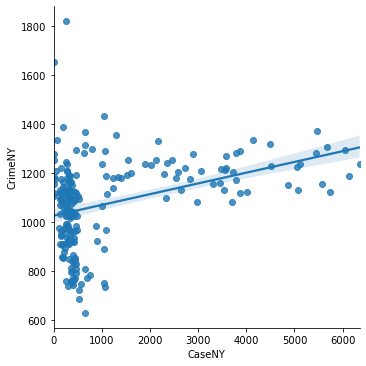

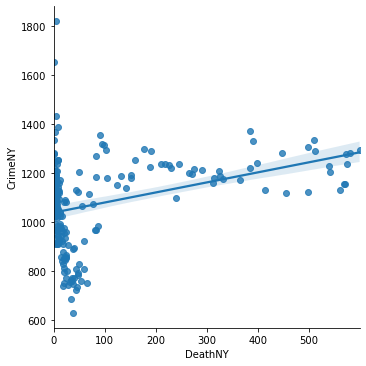

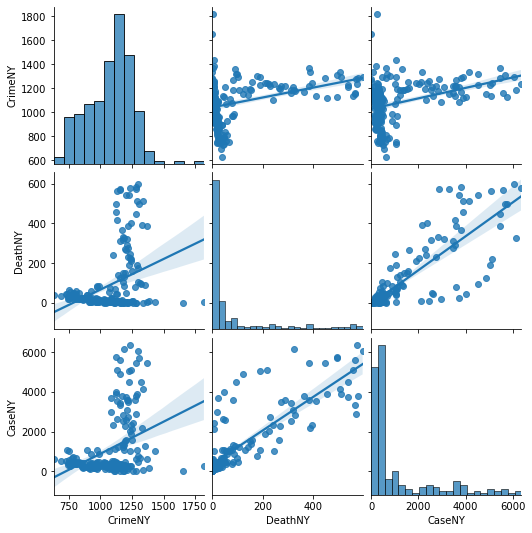

In [41]:
# Demonstrate correlations
sns.lmplot(y='CrimeNY', x='CaseNY', data=crimecovid)
sns.lmplot(y='CrimeNY', x='DeathNY', data=crimecovid)
# Pairwise Plot
sns.pairplot(crimecovid, vars=['CrimeNY', 'DeathNY', 'CaseNY'],kind='reg')  

- Pair plot shows the crime case in NY shows a normal distribution with a median and mean around 1125 complaints per day. The daily number of covid cases and death in NY are skewed to the left : have most of days condensed in low nuber of cases.
- The pair plot shows clear positive correlation trend between 'DeathNY' and 'CaseNY', which makes intuitively sense. But no help on our analysis on crime's predictors/
- The 'CrimeNY' -- 'CaseNY' and 'CrimeNY' -- 'DeathNY' also show positive correlation and show similar pattern of distribution. But number of complaints are widely distrubted from low to high when the daily number of cases/death is low; And number of complaints are condensed closer to the line of fitness as the daily case/death increases.

### LA
From the results of this regression model with Cases and Total death in Los Angeles as the independent variable, and Crime number in Los Angeles as the dependent variable, we can conclude some meaningful patterns. 

- ${R^2}$ = 0.813, Adjusted ${R^2}$ = 0.811 : this model provides a good fit of its inputs.
- **Hypothesis Testing**
    - Ho: coefficient of Cases in LA = 0, Ha: coefficient of Cases in LA ≠ 0.
    - p-values for Cases in LA = 0.04 
    - Ho: coefficient of Deaths in LA = 0, Ha: coefficient of Deaths in LA ≠ 0.
    - p-value for Deaths in LA = 0.00
    - Both t-tests are significant at 0.05 level, indicating the results are strong enough to reject the null hypothesis.
- From the coefficients: with one unit of increase in covid case in LA, the crime number in LA on average will increase by 0.0429. With one unit of increase in covid death number in LA, on average the crime number in LA will increase by 13.036, indicating a positive correlation between both covid case & covid death and the crime number in LA.

In [42]:
X = crimecovid[['CaseLA','DeathLA']]
y = crimecovid["CrimeLA"]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrimeLA   R-squared (uncentered):                   0.813
Model:                            OLS   Adj. R-squared (uncentered):              0.811
Method:                 Least Squares   F-statistic:                              455.7
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                    4.04e-77
Time:                        17:55:50   Log-Likelihood:                         -1455.7
No. Observations:                 212   AIC:                                      2915.
Df Residuals:                     210   BIC:                                      2922.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CaseLA         0.0429      0.021      2.041      0.042       0.001       0.084
DeathLA       13.0356      0.951     13.702      0.000      11.160      14.911
==============================================================================
Omnibus:                       11.301   Durbin-Watson:                   0.270
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                9.266
Skew:                           0.422   Prob(JB):                      0.00972
Kurtosis:                       2.419   Cond. No.                         88.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

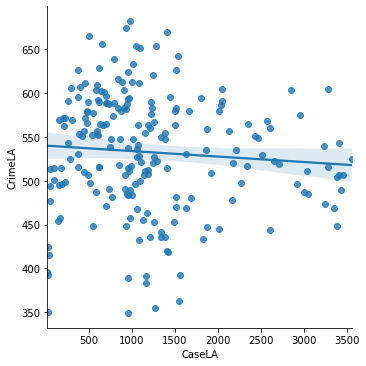

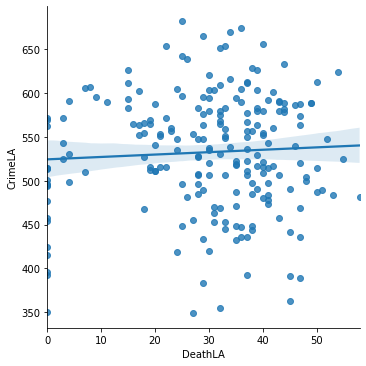

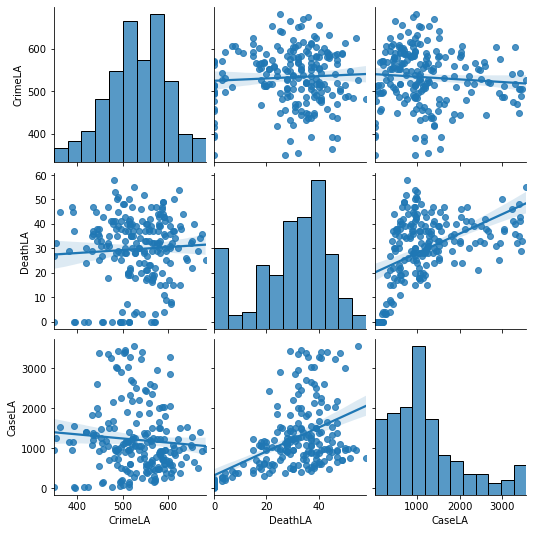

In [43]:
# Demonstrates a negative correlation between the number of cases in LA 
# and the crime in LA. The line does not fit the scatters really well.
sns.lmplot(y='CrimeLA', x='CaseLA', data=crimecovid)

# Positive correlation between the covid death and crime number in LA. 
# However, the scatters are less concentrated.
sns.lmplot(y='CrimeLA', x='DeathLA', data=crimecovid)

# Pairwise Plot
sns.pairplot(crimecovid, vars=['CrimeLA', 'DeathLA', 'CaseLA'],kind='reg')  

- Pair plot demonstrates clearer trend between some of the variables. We can identify a positive trend between the cases in LA vs death in LA: The number of cases in LA will likely increase with the increase in the number of covid death.

- Crime number in LA shows a normal distribution with a median and mean around 550 per day. Death number in LA also presents a likely normal distribution with a median and mean acount 35 per day. In contrast, covid cases in LA has a distribution that is skewed to the right, with a mode around 1000, median and mean slightly greater than 1000 per day.

**Possible "Real-World" Causal Mechanisms for positive correlation between COVID and crime:**
>As daily crime cases increases, __more people suffered from unemployment__. Thus, driven by need for meeting basic living cost, more people might be engaged with __minor offences like theft, or severe ones like bulary__.<br>
>Other mechanism might be, as daily covid cases would directly impact on the quarantine policies of the states. As daily covid cases increase, __stricter policies may have caused more exhaustion and loathe__, and people may be tempted to conduct crime to __"retaliate"__.<br>
>Another reason might be __longer time to shop online__. With rising daily case, there are stricter quarantine cases but also rising awareness of voluntary self-quaratnine out of fear of affection. As a result, __more Cyber-enabled financial crime__ can happen.

**Possible "Real-World" Causal Mechanisms for negative correlation between COVID and crime:**
>In real world, many factors would contribute to crime rate. Pandemic may not be the most significant one compared to policing strength and community public order, which is already settled in NYC and unlikely to be altered much. As much as increasing daily covid case could theoretically increase crime rate due to mentioned reasons, it can also opposingly deters some people from conduting crime, counter-effects leads to weak positive. Some __counter-effective 'negative correlation' mechanism__ include:
   >- The severity of Covid may increase the danger and risk of going outside and conducting crime; <br/>
   >- As daily covid cases increase, quarantine policies are sticter and less people going outside. Thus there are less targets for crimes like theft or bulgary.<br/>
   >- There are much less crowded gathering in clubs and bars, thus there are less alcohol-affected assualts."

# 5. Prediction

In [44]:
covidtrain = coviddata.truncate('2020-03-01', '2020-09-28') # Prepare training data: upto 9/28/20
covidvalid = coviddata.truncate('2020-09-29', '2020-11-18') # We will use data upto 11/18/20 as validation data
covidtest = coviddata.truncate('2020-11-19')  # We will use data after 11/18/20 as testing data
coviddata.head()

,NYCase,NYDeath,LACase,LADeath
date_of_interest,,,,
2020-02-29,1,0,25,0
2020-03-01,0,0,19,0
2020-03-02,0,0,13,0
2020-03-03,1,0,19,0
2020-03-04,5,0,33,0


## 5.1 Forecasting COVID daily data with ARIMA models
* Exponential smoothing and Auto-regressive integrated moving average (ARIMA) models are the two most well-known and widely used approaches to time series forecasting, providing complementary approaches to the problem -- while exponential smoothing models are good at modeling data with trends and seasonality, ARIMA models perform better in stationary situations. 

* Based on the pandemic's uncertain characteristics, we think the ARIMA models bodes a better choice than exponential smoothing. We will apply ARIMA models on COVID-19 daily data to predict the future development of the pandemic. Together with the linear regression model for crime and potential factors, we could predict the crime rate movement in the near future.

### 5.1.1 NY
Before calling the `auto_arima()` function, we will perform some exploratory study of data seasonality in order to help determine specific values used for parameters. The `left column` has diagonostic plots for daily cases, and the `right column` has diagonostic plots for daily deaths. 

We will look at a line plot of an `autocorrelation plot (ACF)`, and a `partial autocorrelation plot (PACF)` of the data. 
- The ACF plot presents the correlation between the data on one day and 'n' day before. Here, the number n is called ‘lag’; it is presented on the x-axis of the plots below. The y-value is the correlation coefficient between those two points. What the ACF plot tells us is essentially the effects one day's data acts on the days following, or you can take it as the similarity between those two days. The higher the y-value, the more similar those two points are. The PACF also indicates this same thing but from another perspective. These two plots play a key role in the manual ARIMA model building process - we determine parameters based on their behaviors. But, since we use the auto_arima() function to do most of the work for us, we only need to use these plots to determine the seasonality here.
- From the ACF plot on the left, we observe an apex every seven-days, which means the similarity of the NYCase data between seven days is relatively high - there seems to be a seven-day periodicity in the NYCase data. The ACF plot of NYDeath on the right, on the other hand, shows no periodicity but a smooth curve. It suggests that there is no seasonality in the NYDeath data. We will build our ARIMA models accordingly.


/Applications/anaconda3/envs/INFO2950/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


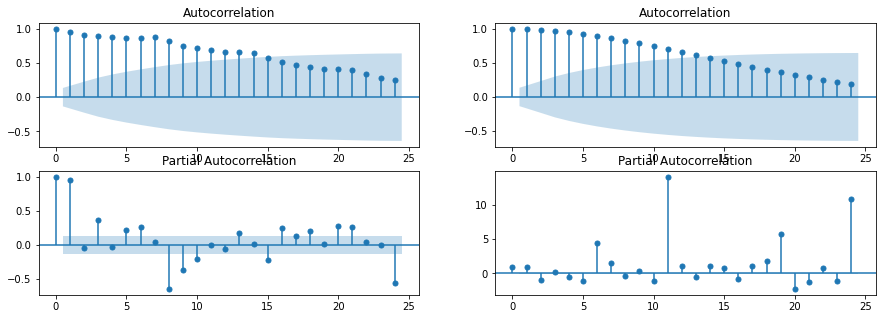

In [45]:
# make ACF and PACF plots for modeling purposes.
fig, axs = plt.subplots(2,2, figsize=(15, 5))
plot_acf(covidtrain["NYCase"], ax=axs[0, 0])
plot_acf(covidtrain["NYDeath"], ax=axs[0, 1])
plot_pacf(covidtrain["NYCase"], ax=axs[1, 0])
plot_pacf(covidtrain["NYDeath"], ax=axs[1, 1])
plt.show()

>The ACF plots' behavior suggests that there seems to be a seven-day periodicity and no seasonality in the NYCase and NYDeath data, respectively. We will build our ARIMA models accordingly.


Next, we can go ahead with our ARIMA model. The process of parameter selection involves:
>-  Each step the function generates a new version of the ARIMA model, and records according accuracy, and the time it takes for calculation. We choose the Akaike information criterion (AIC) as the estimator of prediction error. After looking through possible candidates of each parameter, the function returns an ARIMA model with the lowest AIC.
>- We then overlay the prediction onto the line plot of NY cases and deaths.

**For readability consideration, we will omit the tuning process of the all ARIMA models.**

See below for the ARIMA plots for NY Cases and Deaths. `Blue curve` is the observed training daily cases and deaths of NY. `Orange curve` is the testing data of daily cases and deaths. `Green curve` is the forecast prediction generated by the function.

In [46]:
# NY Cases
# Develop an ARIMA model using auto ARIMA function and predict
arima_model_ny_case = auto_arima(covidtrain["NYCase"], start_p=0, error_action='ignore', m=7, seasonal=True, D = 2,suppress_warnings=True, stepwise=True, random_state=20, n_fits=50)
prediction_ny_case = pd.DataFrame(arima_model_ny_case.predict(n_periods = len(covidvalid[["NYCase", "NYDeath"]])), index=covidvalid[["NYCase", "NYDeath"]].index)
prediction_ny_case.columns = ['predicted_cases_ny']

# NY Deaths
# Develop an ARIMA model using auto ARIMA function and predict
arima_model_ny_death = auto_arima(covidtrain["NYDeath"], start_p=0, error_action='ignore', m=7, seasonal=True, D = 2,suppress_warnings=True, stepwise=True, random_state=20, n_fits=50)
prediction_ny_death = pd.DataFrame(arima_model_ny_death.predict(n_periods = len(covidvalid[["NYCase", "NYDeath"]])), index=covidvalid[["NYCase", "NYDeath"]].index)
prediction_ny_death.columns = ['predicted_deaths_ny']

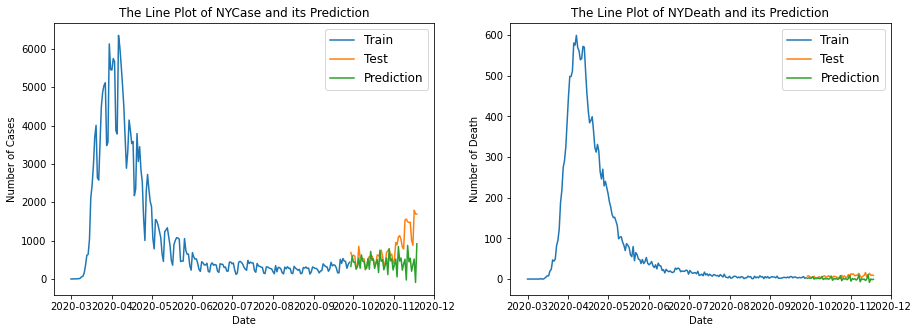

In [47]:
# visualize the prediction
plt.subplots(1,2, figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(covidtrain["NYCase"], label='Train')
plt.plot(covidvalid["NYCase"], label='Test')
plt.plot(prediction_ny_case['predicted_cases_ny'], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(prop={'size': 12})
plt.title('The Line Plot of NYCase and its Prediction')

plt.subplot(1, 2, 2)
plt.plot(covidtrain["NYDeath"], label='Train')
plt.plot(covidvalid["NYDeath"], label='Test')
plt.plot(prediction_ny_death['predicted_deaths_ny'], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Death')
plt.legend(prop={'size': 12})
plt.title('The Line Plot of NYDeath and its Prediction')
plt.show()

**NY ARIMA Evaluation with Testing Data**
>- As is shown above, the model performs pretty well at the beginning of the test set. But the residual begins to increase rapidly after a short period of time. This may not be a serious problem since we can always update our model with new data.
>- According to the graph, the model makes quite accurate prediction on the NYDeath data due to low volatility.

Quantitatively, we will use `mean square error (MSE)` and `normalized root-mean-squared deviation (NRMSD)` to evaluate our forecast performance. The MSE measures the average squares of the errors -- the average squared difference between the estimated values and the actual value. The smaller the MSE value, the more accurate the model is. The scale of MSE is largely determined by how large the actual values are. To account for COVID count variability and to compare accuracy of all prediction on the same scale, we will mainly rely on NRMSD.

In [48]:
# performance evaluation
mse_NYCase = mean_squared_error(covidvalid['NYCase'], prediction_ny_case['predicted_cases_ny'])
nrmsd_NYCase = np.sqrt(mse_NYCase) / np.mean(covidvalid['NYCase'])
print('The mean squared error of NYCase: {:.2f}'.format(mse_NYCase))
print('The normalized root-mean-squared deviation of NYCase: {:.2f}'.format(nrmsd_NYCase))

mse_NYDeath = mean_squared_error(covidvalid['NYDeath'], prediction_ny_death['predicted_deaths_ny'])
nrmsd_NYDeath = np.sqrt(mse_NYDeath) / np.mean(covidvalid['NYDeath'])
print('The mean squared error of NYDeath: {:.2f}'.format(mse_NYDeath))
print('The normalized root-mean-squared deviation of NYDeath: {:.2f}'.format(nrmsd_NYDeath))

The mean squared error of NYCase: 307390.63
The normalized root-mean-squared deviation of NYCase: 0.71
The mean squared error of NYDeath: 68.26
The normalized root-mean-squared deviation of NYDeath: 1.20


According to the NRMSD values, it seems like the ARIMA models did not perform well in the prediction of NY COVID cases compared to NY death counts. However, when we account for the size of COVID counts, we find better predictions for NY case counts instead.

NY ARIMA Interpretation and Conclusion
The ARIMA model of the NYCase provides relatively accurate predictions for approximately one month before breaking up with the test set. That’s because there is a four-month period where the daily diagnosed cases number stays at the same level with small fluctuations. It does not start to grow until the end of the training set. The model does not catch that trend. 
The model of the NYDeath also performs well in the first month before the residual begins to grow.

### 4.3.2 LA
We have finished predicting New York's COVID data; now, let's turn to Los Angeles County.

As usual, we first observe the seasonality of the data. The `left column` has diagonostic plots for daily cases, and the `right column` has diagonostic plots for daily deaths. We will look at `ACF plot`, and `PACF plot` of the LA COVID data.

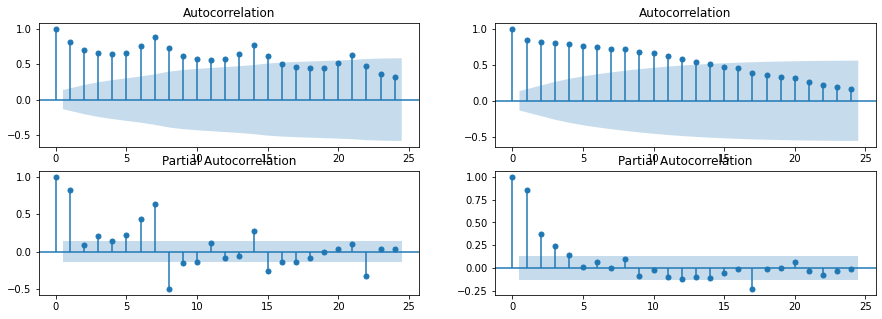

In [49]:
# make ACF and PACF plots for modeling purposes.
fig, axs = plt.subplots(2,2, figsize=(15, 5))
plot_acf(covidtrain["LACase"], ax=axs[0, 0])
plot_acf(covidtrain["LADeath"], ax=axs[0, 1])
plot_pacf(covidtrain["LACase"], ax=axs[1, 0])
plot_pacf(covidtrain["LADeath"], ax=axs[1, 1])
plt.show()

>The ACF plots' behavior suggests that there seems to be a seven-day periodicity and no seasonality in the LACase and LADeath data, respectively. We will build our ARIMA models accordingly.

See below for the ARIMA plots for LA Cases and Deaths. `Blue curve` is the observed training daily cases and deaths of NY. `Orange curve` is the testing data of daily cases and deaths. `Green curve` is the forecast prediction generated by the function.

In [50]:
# LA Cases
# Develop an ARIMA model using auto ARIMA function and predict
arima_model_la_case = auto_arima(covidtrain["LACase"], start_p=0, error_action='ignore', m=7, seasonal=True, D = 2,suppress_warnings=True, stepwise=True, random_state=20, n_fits=50)
prediction_la_case = pd.DataFrame(arima_model_la_case.predict(n_periods = len(covidvalid[["LACase", "LADeath"]])), index=covidvalid[["LACase", "LADeath"]].index)
prediction_la_case.columns = ['predicted_cases_la']

# LA Deaths
# Develop an ARIMA model using auto ARIMA function and predict
arima_model_la_death = auto_arima(covidtrain["LADeath"], start_p=0, error_action='ignore', m=7, seasonal=True, D = 2,suppress_warnings=True, stepwise=True, random_state=20, n_fits=50)
prediction_la_death = pd.DataFrame(arima_model_la_death.predict(n_periods = len(covidvalid[["LACase", "LADeath"]])), index=covidvalid[["LACase", "LADeath"]].index)
prediction_la_death.columns = ['predicted_deaths_la']

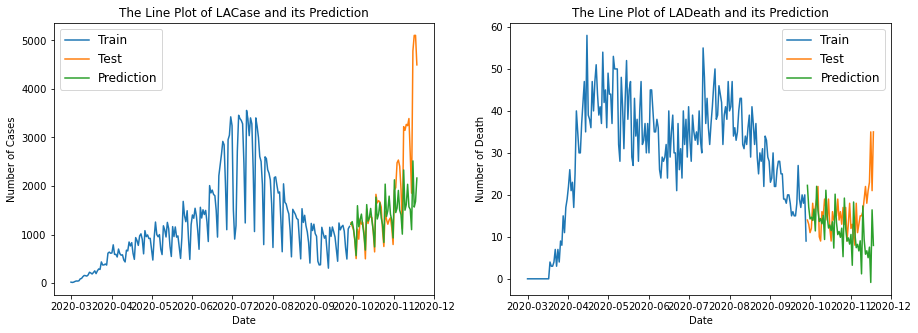

In [51]:
# visualize the prediction
plt.subplots(1,2, figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(covidtrain["LACase"], label='Train')
plt.plot(covidvalid["LACase"], label='Test')
plt.plot(prediction_la_case['predicted_cases_la'], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(prop={'size': 12})
plt.title('The Line Plot of LACase and its Prediction')

plt.subplot(1, 2, 2)
plt.plot(covidtrain["LADeath"], label='Train')
plt.plot(covidvalid["LADeath"], label='Test')
plt.plot(prediction_la_death['predicted_deaths_la'], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Death')
plt.legend(prop={'size': 12})
plt.title('The Line Plot of LADeath and its Prediction')
plt.show()

**LA ARIMA Evaluation with Testing Data**
>- After we overlay the prediction onto the line plot of LACase. The model performs really well on the test set, especially for the days early on in the forecast segment.
>- According to the second graph, the result is unsatisfying. More adjustments on the auto_arima() function's parameters are needed for LA death counts.

Quantitatively, we will use mean square error to evaluate our forecast performance. 

In [52]:
# performance evaluation
mse_LACase = mean_squared_error(covidvalid['LACase'], prediction_la_case['predicted_cases_la'])
nrmsd_LACase = np.sqrt(mse_LACase) / np.mean(covidvalid['LACase'])
print('The mean squared error of LACase: {:.2f}'.format(mse_LACase))
print('The normalized root-mean-squared deviation of LACase: {:.2f}'.format(nrmsd_LACase))

mse_LADeath = mean_squared_error(covidvalid['LADeath'], prediction_la_death['predicted_deaths_la'])
nrmsd_LADeath = np.sqrt(mse_LADeath) / np.mean(covidvalid['LADeath'])
print('The mean squared error of LADeath: {:.2f}'.format(mse_LADeath))
print('The normalized root-mean-squared deviation of LADeath: {:.2f}'.format(nrmsd_LADeath))

The mean squared error of LACase: 1013176.24
The normalized root-mean-squared deviation of LACase: 0.55
The mean squared error of LADeath: 88.15
The normalized root-mean-squared deviation of LADeath: 0.59


Quantitatively, we will use the mean square error to evaluate our forecast performance.
According to the plots, the ARIMA models did not perform well in the prediction of LA COVID death compared to LA cases counts. While we are unable to compare the MSEs across cases and deaths, we relied on the NRMSDs and found similar results.


**Conclusion**
* In this section, the most surprising discovery is the seasonality of the COVID-19 case data. It appears that in both cities, there is a seven-day periodicity in the daily diagnosed cases number. Every weekend, the diagnosed cases number would drop sharply and rise again at the beginning of the next week. 
* Based on this observation, we think exponential smoothing could also be a good candidate for COVID prediction.
* The ARIMA model did not provide a satisfying forecast on the COVID prediction as expected. It results from an improper setting of the modeling function's parameters and the nature of the pandemic data. 

### 4.3.3 ARIMA Predictions
- The last step of our data analysis is to plug COVID forecast results into the linear regression we generated earlier. We are hoping to draw inferences about future changes of crime cases in New York and Los Angeles.

In [64]:
# The COVID data prediction made by ARIMA models.
arima_prediction = prediction_ny_case.copy()
arima_prediction['predicted_deaths_ny'] = prediction_ny_death
arima_prediction['predicted_cases_la'] = prediction_la_case
arima_prediction['predicted_deaths_la'] = prediction_la_death

arima_prediction.head()

,predicted_cases_ny,predicted_deaths_ny,predicted_cases_la,predicted_deaths_la
date_of_interest,,,,
2020-09-29,327.076402,1.662801,1208.870774,22.260665
2020-09-30,592.960486,2.923957,1265.670754,17.062379
2020-10-01,436.383593,2.021125,1122.266205,14.276868
2020-10-02,442.107689,2.287969,901.682990,14.680586
2020-10-03,254.599171,5.973318,565.960652,13.919880


- The table above includes all the predictions our ARIMA models made on the COVID data in both cities. Notice that the data begins at the splitting point, not the end of the testing sets. That's because we do not have access to up-to-date data on the crime rate. The most recent data is on Sep. 29th, 2020. 
- In this project, we are trying to develop a systematic process for the government to predict the crime rate's future movement. This requires up-to-date COVID and Crime data to first develop a regression model; then predict COVID data’s future movement; after that, plugging the COVID prediction into that regression model to obtain the forecast of Crime rate. Although we don’t have access to the most recent crime data, we assume that in practice, governments could manage to obtain those data. So here is just a simulation of our final step: predicting crime rate with COVID predictions.

## 5.2 Bollinger Bands

According to the Bollinger Bounce Property, we expect the COVID counts to bounce from one side of the band to the other. It has a tendency to return to the moving average. When the number of cases breaks out of the upper bound, we expect it to continue the upward trend. When the number of cases breaks out of the lower bound, we expect it to continue to decrease. 

### NY Analysis and Evaluation
**Parameters of Bollinger Bands(BB)**
- Window of Moving Average(MA): 
    - Conventionally, people utilize two types of Bollinger Bands: short and long.
    - Short BB has moving average generated from 5-day lookback windows; whereas long BB has moving average of 20 or 30 days.
    - For NY COVID data, we choose an optimal value of 15-day lookback window that is most sentisitve to the training data.
- Standard Deviation of BB:
    - It is common to use 2 standard deviation as width of the bands
- Method of MA:
    - We attempted two types of MA: Simple Moving Average(SMA) and Exponentially Weighted Moving Average(EWMA)
    - EWMA gives more weight to recent observations and less weight to observations further away from today. 
    - Though it sounds more intuitive than SMA, EWMA produces loose bands that cause insensitivity for high volatility data. Therefore, we will use SMA for BB.

**COVID Cases Training Data Analysis**
- We observe that the early phase of the pandemic has extremely large volatility during March and April.
    - The Bollinger Bands successfully detectes the increase trend of covid cases in March.
    - With the consecutive red dots, the number of cases consecutively break out of the upper bound.
    - Though we observe decrease in cases staring in April, the bands are still very wide, which means that there might be potential bounce backs.
- It was not until the end of April, that the bands indicates a decrease in number of cases with green dots.
    - We also see that the bands started to squeeze.
    - Therefore, we expect number of cases to reduce and stay low in the following months.
- In September, there are three consecutive upper bound breakout signals and the bands expand a little bit.
    - We expect the number of cases increase in the following months, but only by a small amount.

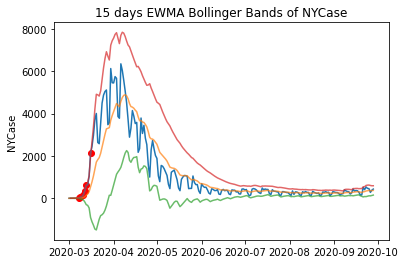

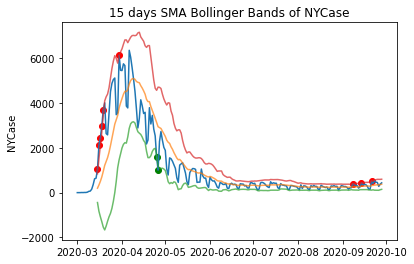

In [61]:
# Case Counts
BollingerBands(covidtrain, 'NYCase', 15, 2, "EWMA", True)    # EWMA gives loose bands
plt.show()
BollingerBands(covidtrain, 'NYCase', 15, 2, "SMA", True)

**COVID Deaths Training Data Analysis**
- We observe very similar signals for case and death, as expected. In particular, the early phase of the pandemic has extremely large volatility during March and April. And the trend of death cases slightly lags behind positive cases.
    - The Bollinger Bands successfully detects the increase trend of deaths from mid-March to mid-April.
    - With the consecutive red dots, the number of deaths consecutively break out of the upper bound.
    - Very quickly in mid-April, as soon as cases starts to drop, we see green dots, indicating future decrease in deaths.
    - In other words, number of deaths follows closely with number of cases.
- Up to October, we observe no red dots, so we expect number of deaths to reduce and stay low in the following months.

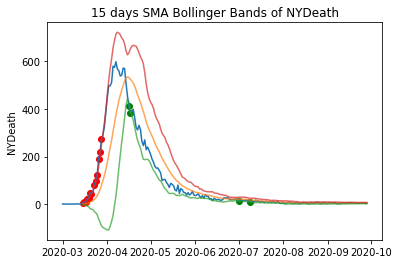

In [54]:
# Death counts
BollingerBands(covidtrain, 'NYDeath', 15, 2, "SMA", True)

**Testing Data Evaluation**
- According to the plots, we do observe a slight increase in number of cases and deaths.
- The Bollinger Bands give reliable prediction indeed.

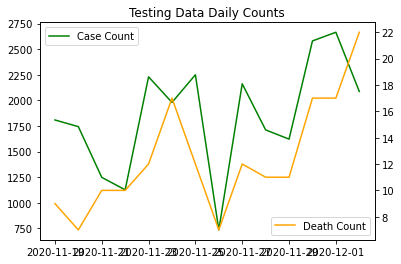

In [55]:
# plot daily counts
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

lns1 = ax_left.plot(covidtest['NYCase'], label="Case Count", color='green')
lns2 = ax_right.plot(covidtest['NYDeath'], label="Death Count", color='orange')
plt.title("Testing Data Daily Counts")
labs = [l.get_label() for l in lns1]
ax_left.legend(lns1, labs, loc=0)
labs = [l.get_label() for l in lns2]
ax_right.legend(lns2, labs, loc=4)
plt.show()

### LA Analysis and Evaluation
**Parameters of Bollinger Bands(BB)**
- Window of Moving Average(MA): 
    - For LA COVID data, we choose an optimal value of 20-day lookback window that is most sentisitve to the training data.

**COVID Cases Training Data Analysis**
- We observe that the pandemic has growing positive daily cases and volatility from March to June.
    - The Bollinger Bands successfully detectes the increase trend of covid cases in March.
    - With the consecutive red dots, the number of cases consecutively break out of the upper bound.
    - The bands are remain extremly wide in July, which indicates the uncertanties of future pandemic behavior.
- It was not until the end of July, that the bands indicates the first decrease signal in number of cases with green dots.
    - Together with the slight squeeze of bands, we expect number of cases to remain relatively stable in the following months.
    - It is worth noting the certainties due to pretty wide band width by the end of September.

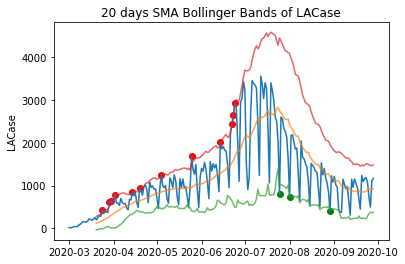

In [56]:
# Case Counts
BollingerBands(covidtrain, 'LACase', 20, 2, "SMA", True)

**COVID Deaths Training Data Analysis**
- We observe quite different signals for case and death. In particular, the early phase of the pandemic has rapid growth of deaths, when daily cases was low during March and April. 
    - The Bollinger Bands successfully detectes the increase trend of deaths from mid-March to mid-April.
    - With the consecutive red dots, the number of deaths consecutively break out of the upper bound.
    - Different from the growing trend of number of cases, we observe first decrease signal of number of deaths in mid-May. In fact, we do see a decline from May to June.
- From April to August, Bollinger Bands gives alternating upward and downward signals. This is an indicator of ranging behavior. 
    - Ranging pandemic means that number of deaths will bounce between upper and lower bounds. There is a tendency for deaths return to the moving average. 
    - If we have consecutive signals, the we escape the ranging behavior.
- In September, we are still in ranging pandemic and our last signal is a downward signal. Therefore, we are expecting the number of deaths to bounce within the bands and remain stable. So the number of deaths will only fluctuate slightly.

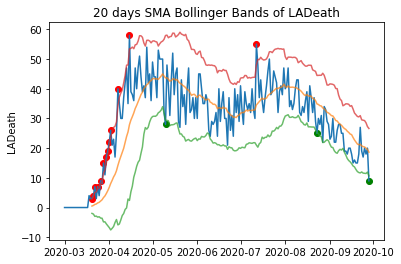

In [57]:
# Death counts
BollingerBands(covidtrain, 'LADeath', 20, 2, "SMA", True)

**Evaluation of Significance with Testing Data**
- According to the plots, we do observe a slight increase in number of cases, and slight decrease in deaths.
- The Bollinger Bands is correct in the volatility of the pandemic, but ambiguous in the direction of movement for LA.

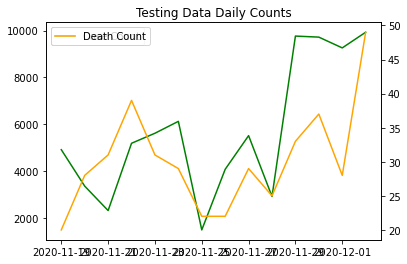

In [58]:
# plot daily counts
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

lns1 = ax_left.plot(covidtest['LACase'], label="Case Count", color='green')
lns2 = ax_right.plot(covidtest['LADeath'], label="Death Count", color='orange')
plt.title("Testing Data Daily Counts")
labs = [l.get_label() for l in lns1]
ax_left.legend(lns1, labs, loc=0)
labs = [l.get_label() for l in lns2]
ax_right.legend(lns2, labs, loc=0)
plt.show()

### 5.2.3 Interpretation and conclusions
**NY**
- After performing Bollinger Bands on NY up-to-date COVID, we observe upward signals for daily cases in early November, together with a slight increase in volatility. Then the bands starts to squeeze in mid-November, so we expect that volatility will decrease and the number of cases will flatten out in the near future.
- There's not much movement for number of deaths in the near future.

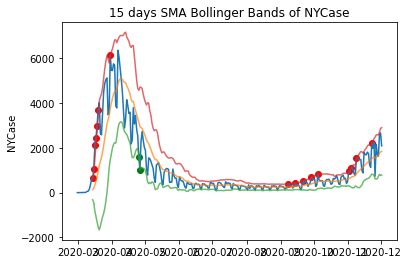

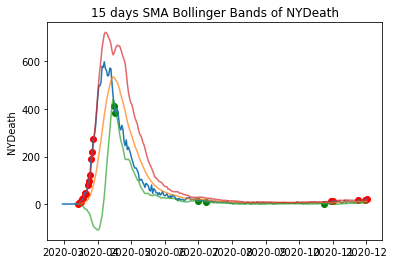

In [62]:
# We will now run analysis for full up-to-date datasets, and derive conclusion about future.
BollingerBands(coviddata, 'NYCase', 15, 2, "SMA", True)
plt.show()
BollingerBands(coviddata, 'NYDeath', 15, 2, "SMA", True)

**LA**
- After performing Bollinger Bands on LA up-to-date COVID, we observe upward signals for daily cases in early November, together with an expanding volatility. Due to wide bands, we loose prediction accuracy, but the number of cases will continue its upward trend in the near future.
- The number of deaths will flatten out with growing volatility in the near future.

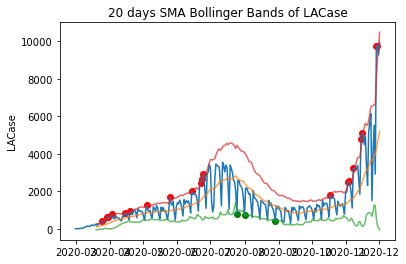

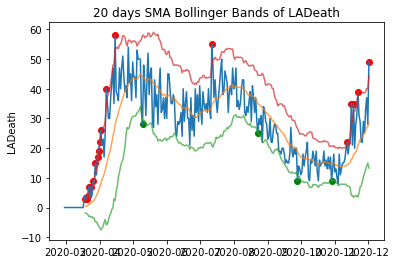

In [63]:
BollingerBands(coviddata, 'LACase', 20, 2, "SMA", True)
plt.show()
BollingerBands(coviddata, 'LADeath', 20, 2, "SMA", True)

In general, we are much more confident in predicting the future behavior of NY data due to it's low volatility and historical consistency. We have many uncertaintied about the future movement of LA data. We can combine Bollinger Bands results with other forecasting methods for more confidence.